In [1]:
import re
import csv
import sys
import random
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:

# import tables for Java, python and R
rUsers= pd.read_csv("r_users.csv")
pythonUsers= pd.read_csv("python_users.csv")
javaUsers=pd.read_csv("java_users.csv") 

javaQuestions = pd.read_csv("java_questions.csv",sep=";",error_bad_lines=False)
pythonQuestions= pd.read_csv("python_questions.csv",error_bad_lines=False)
rQuestions= pd.read_csv("r_questions.csv")

javaAnswers = pd.read_csv("java_answers.csv",error_bad_lines=False)
pythonAnswers = pd.read_csv("python_answers.csv",error_bad_lines=False) 
rAnswers= pd.read_csv("r_answers.csv")

# read Barbara's metric
rProbAcc=pd.read_csv("barbarametric.csv") 
rProbAcc = rProbAcc.sort_values([' CreationDate'])

# read Degree metric
rDegree=pd.read_csv("lil_degree.csv") 
rDegree = rDegree.sort_values([' CreationDate'])

# read Nirmal's metric betweeness
rBetween = pd.read_csv("lil_between.csv")
rBetween = rBetween.sort_values(['CreationDate','UserId'])

# read Nirmal's metric 2 closeness
rClose = pd.read_csv("lil_close.csv") 
rClose = rClose.sort_values(['CreationDate', 'UserId'])

# read Nirmal's metric 3 eigen 
rEig = pd.read_csv("lil_eig.csv") 

rEig = rEig.sort_values(['CreationDate','UserId']) 


b'Skipping line 325621: expected 10 fields, saw 23\n'
b'Skipping line 336660: expected 10 fields, saw 74\nSkipping line 366638: expected 10 fields, saw 19\n'
b'Skipping line 455722: expected 10 fields, saw 11\n'
b'Skipping line 804123: expected 10 fields, saw 19\n'
b'Skipping line 865079: expected 10 fields, saw 12\nSkipping line 866131: expected 10 fields, saw 15\n'
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
b'Skipping line 1122646: expected 7 fields, saw 12\n'


In [3]:
 
# function upMetricCreation    
# parameter : table
# returns : table with extra columns
# Summary : Adds a new metric that is based on the CumScore achieved so far by the user dividid
# by the number of answers answered until a certain point in time
# Step-by-step:
# considers the absolute total score within a question
# add the score per question as a column in the answersTable by merging
# considers a relative score that each user has within a question
# the number of cumulative questions (per user) answered so far is added as a column
# the order per user and creation date has to be maintained in order to make a cumulative score through the questions
# the UpMetric is calculated based on : cumScore/cumSumQuestions in a certain point in time 
# this value/metric changes every time a user answers a question
def upMetricCreation(table):
    answersTable = table.copy()
    
    answersTable[' AbsSum']= answersTable[' Score'].abs()

    # the absolute total score by question
    questiondf = answersTable.groupby([' ParentId'])[' AbsSum'].sum()
    
    questiondf = pd.DataFrame(questiondf)
    questiondf= questiondf.reset_index()
                
    #merge the table of answers and question
    answersTable= answersTable.merge(questiondf,left_on=' ParentId',suffixes=('', 'Global'), right_on=' ParentId', how='left')
    answersTable   
    
    # Score relative to the question, multiplied by the signal of the "individual" score
    answersTable[' RelativeScore'] =  answersTable[' AbsSum'] / answersTable[' AbsSumGlobal']  
    
    answersTable.loc[answersTable[' Score'] < 0,' RelativeScore'] = - answersTable[' RelativeScore'] 
    answersTable.loc[answersTable[' Score'] == 0,' RelativeScore'] =0
    
    # The cum. number of questions answers by user 
    answersTable['CumSumQuestions'] = answersTable.groupby(' OwnerUserId').cumcount() + 1
    
    answersTable=answersTable.sort_values([' OwnerUserId',' CreationDate']) #order by user
    
    answersTable['CumScore'] = answersTable.groupby(' OwnerUserId')[' RelativeScore'].cumsum()
    
    
    answersTable=answersTable.sort_values([' OwnerUserId',' CreationDate']) #order by user
    
    

    answersTable['UpMetric'] = answersTable['CumScore']/answersTable['CumSumQuestions'] 
    return(answersTable)



In [4]:
# UpMetric creation for every language
rAnswers = upMetricCreation(rAnswers)
pythonAnswers = upMetricCreation(pythonAnswers)
javaAnswers = upMetricCreation(javaAnswers)

In [5]:
# function formatCreationDateColumn    
# parameter : table
# returns : table 
# Summary : Converts the creationDate field into a datetime format
def formatCreationDateColumn(table_provided):
    table = table_provided.copy()
    #Correcting format of dates in the table
    table[' CreationDate']=pd.to_datetime(table[' CreationDate'],errors="coerce")
    
    #remove lines which could not be formatted to correct date format
    table=table.loc[~table[" CreationDate"].isnull()]
    
    return(table)

def formatCreationDateColumn1(table_provided):
    table = table_provided.copy()
    #Correcting format of dates in the table
    table['CreationDate']=pd.to_datetime(table['CreationDate'],errors="coerce")
    
    #remove lines which could not be formatted to correct date format
    table=table.loc[~table["CreationDate"].isnull()]
    
    return(table)

In [6]:
# format data column for all the tables
rAnswers = formatCreationDateColumn(rAnswers)
javaAnswers = formatCreationDateColumn(javaAnswers)
pythonAnswers = formatCreationDateColumn(pythonAnswers)

rQuestions = formatCreationDateColumn(rQuestions)
javaQuestions = formatCreationDateColumn(javaQuestions)
pythonQuestions = formatCreationDateColumn(pythonQuestions)

rEig = formatCreationDateColumn1(rEig)
rBetween = formatCreationDateColumn1(rBetween)
rClose = formatCreationDateColumn1(rClose)

In [7]:
# function gettingTableUserFirstActivity
# parameter : answersTable, questionsTable
# returns : firstActivityTable  
# Summary : I looks for the first question date and first answer date, chooses the minimum and puts 
# it on the firstActivityTable (per user)
def gettingTableUserFirstActivity(answersTable_provided,questionsTable_provided):
    answersTable = answersTable_provided.copy()
    questionsTable = questionsTable_provided.copy()
   
    #identify the first activity of users
    answersTable["FirstActivity"]=~answersTable[" OwnerUserId"].duplicated()
    questionsTable["FirstActivity"]=~questionsTable[" OwnerUserId"].duplicated()
    
    #obtaining first answer and first question of a user
    firstAnswers=answersTable.loc[answersTable["FirstActivity"]==True][[" OwnerUserId"," CreationDate"]]

    firstQuestions = questionsTable.loc[questionsTable["FirstActivity"]==True][[" OwnerUserId"," CreationDate"]]
  
    #and merge them into one table
    firstActTable=firstQuestions.merge(firstAnswers, left_on=" OwnerUserId", right_on=" OwnerUserId", how='outer')
    firstActTable.columns = [" OwnerUserId","FirstQuestion","FirstAnswer"]
    
    #obtain first activity (either answer or question)
    firstActTable["FirstActivity"]=firstActTable[["FirstQuestion","FirstAnswer"]].min(axis=1)
    
    
    return(firstActTable)

In [8]:
# get first activity per user in all the languages
rFirstActTable = gettingTableUserFirstActivity(rAnswers,rQuestions)
javaFirstActTable = gettingTableUserFirstActivity(javaAnswers,javaQuestions)
pythonFirstActTable = gettingTableUserFirstActivity(pythonAnswers,pythonQuestions)

In [9]:
# function obtainSummaryUpMetric
# parameter : answersTable, questionsTable, FirstActivityTable
# returns : summaryTable  
# Summary : It normalizes the time by Merging the answersTable with the FirstActTable, defines a new column 
# "Present" as the most recent Answer date calculates the difference between the creation of the answers and 
# the date of the first activity of the usercalculates the differente between the last answer of the user
# and he's first activity date both measured in days and then the days are normalized
def obtainSummaryUpMetric(answersTable,questionsTable,firstActTable):
    
    #Adding first activity table to answerstable 
    summaryTableAnswer = answersTable[["Id"," OwnerUserId"," CreationDate"," ParentId","UpMetric"]]
    summaryTableAnswer=summaryTableAnswer.merge(firstActTable,left_on = " OwnerUserId",right_on=" OwnerUserId")
    
    #Use first activity to obtain normalized time
    summaryTableAnswer["Present"]= max(summaryTableAnswer[" CreationDate"])
    
    #timestamp of answer compared to first activity of that user
    summaryTableAnswer["DifferenceNumerator"]=(summaryTableAnswer[" CreationDate"]-summaryTableAnswer["FirstActivity"])
    summaryTableAnswer["DifferenceDenominator"]=(summaryTableAnswer["Present"]-summaryTableAnswer["FirstActivity"])
    
    summaryTableAnswer.DifferenceNumerator=summaryTableAnswer.DifferenceNumerator.dt.total_seconds() /(24*3600) # to obtain days with decimals
    summaryTableAnswer.DifferenceDenominator=summaryTableAnswer.DifferenceDenominator.dt.total_seconds()/(24*3600)
    summaryTableAnswer["NormTime"]=summaryTableAnswer["DifferenceNumerator"]/summaryTableAnswer["DifferenceDenominator"]
    
    return(summaryTableAnswer)

In [10]:
# obtainSummaryUpMetric per language
rSummaryUpMetricAnswer = obtainSummaryUpMetric(rAnswers,rQuestions,rFirstActTable)
rSummaryUpMetricAnswer = rSummaryUpMetricAnswer.sort_values([' CreationDate'])
javaSummaryUpMetricAnswer = obtainSummaryUpMetric(javaAnswers,javaQuestions,javaFirstActTable)
javaSummaryUpMetricAnswer = javaSummaryUpMetricAnswer.sort_values([' CreationDate'])
pythonSummaryUpMetricAnswer = obtainSummaryUpMetric(pythonAnswers,pythonQuestions,pythonFirstActTable)
pythonSummaryUpMetricAnswer = pythonSummaryUpMetricAnswer.sort_values([' CreationDate'])

In [11]:
def removeUsersWithFewAnswers(answersTable,summaryTableAnswer):
    nrQuestionsperUser = answersTable[" OwnerUserId"].value_counts()
    lessthan5users=nrQuestionsperUser[nrQuestionsperUser<5].index
    nrUsersBefore=len(list(set(summaryTableAnswer[" OwnerUserId"].tolist())))
    filteredTable=summaryTableAnswer.loc[~summaryTableAnswer[" OwnerUserId"].isin(lessthan5users)]
    nrUsersAfter=len(list(set(filteredTable[" OwnerUserId"].tolist())))
    print(1-nrUsersAfter/nrUsersBefore,"% of the users were removed.")
    return(filteredTable)

In [12]:
# take away users with few answers
rSummaryUpMetricAnswerFew = removeUsersWithFewAnswers(rAnswers,rSummaryUpMetricAnswer)
javaSummaryUpMetricAnswerFew = removeUsersWithFewAnswers(javaAnswers,javaSummaryUpMetricAnswer)
pythonSummaryUpMetricAnswerFew = removeUsersWithFewAnswers(pythonAnswers, pythonSummaryUpMetricAnswer)

0.8437442133201654 % of the users were removed.
0.8169454999149323 % of the users were removed.
0.8319620773003543 % of the users were removed.


In [13]:
def addZeroTimepoint(summaryTableAnswer_provided):
    summaryTableAnswer=summaryTableAnswer_provided.copy()
    #Add 0 to time 0
    usersWhoHaveZero=list(set(summaryTableAnswer[" OwnerUserId"][summaryTableAnswer["NormTime"]==0].tolist()))
    usersArtificialZero = list(set(summaryTableAnswer[" OwnerUserId"][~summaryTableAnswer[" OwnerUserId"].isin(usersWhoHaveZero)].tolist()))
    tempdfArtificialZero = pd.DataFrame(0, index=np.arange(len(usersArtificialZero)), columns=list(summaryTableAnswer.columns.values))
    tempdfArtificialZero[" OwnerUserId"]=usersArtificialZero
    tempdfArtificialZero[" OwnerUserId"]=tempdfArtificialZero[" OwnerUserId"].astype(np.int64) # make type correct
    summaryTableAnswer = summaryTableAnswer.append(tempdfArtificialZero, ignore_index=True)

    #reorder again
    summaryTableAnswer=summaryTableAnswer.sort_values([' OwnerUserId','NormTime']) #order by user
    return(summaryTableAnswer)



In [14]:
rSummaryUpMetricAnswerFew = addZeroTimepoint(rSummaryUpMetricAnswerFew)
javaSummaryUpMetricAnswerFew = addZeroTimepoint(javaSummaryUpMetricAnswerFew)
pythonSummaryUpMetricAnswerFew = addZeroTimepoint(pythonSummaryUpMetricAnswerFew)

In [15]:
def plotEvolutionRandomUsers(summaryTableAnswer,language):
    r_users=summaryTableAnswer.loc[np.random.choice(summaryTableAnswer.index, 6)][" OwnerUserId"].tolist()
    plt.figure(figsize=(12,8))

    for i in range(0,6):
        user=r_users[i]
        plt.subplot(3,2,i+1)
        plt.xlabel("Days since first activity in "+language)
        plt.ylabel("Ratio of Up Votes \nwithin a Question")
        plt.plot(summaryTableAnswer.loc[summaryTableAnswer[" OwnerUserId"]==user]["DifferenceNumerator"].tolist(),summaryTableAnswer.loc[summaryTableAnswer[" OwnerUserId"]==user]["UpMetric"].tolist())
    
    plt.tight_layout()
    plt.show()

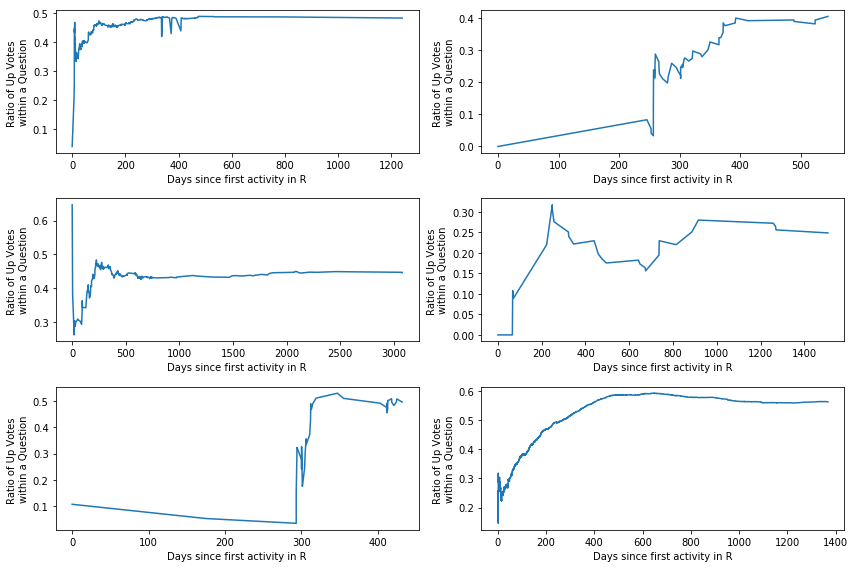

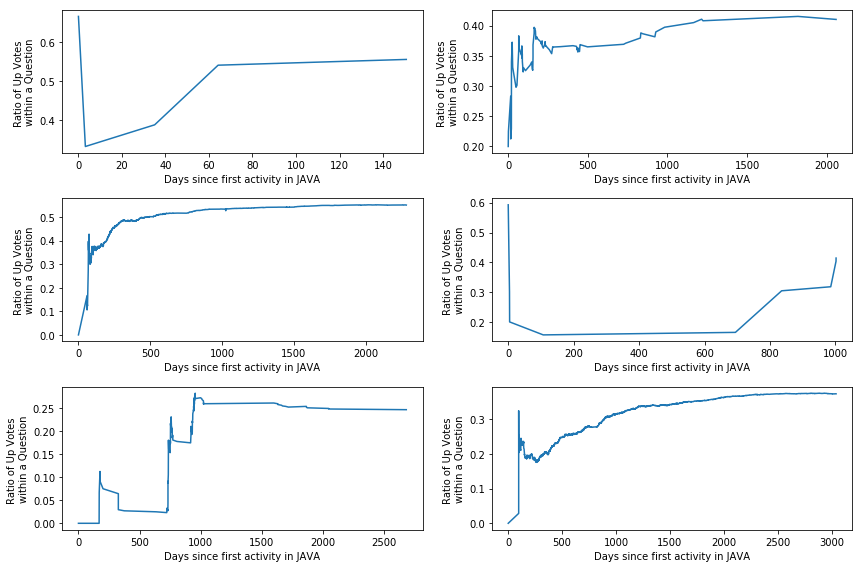

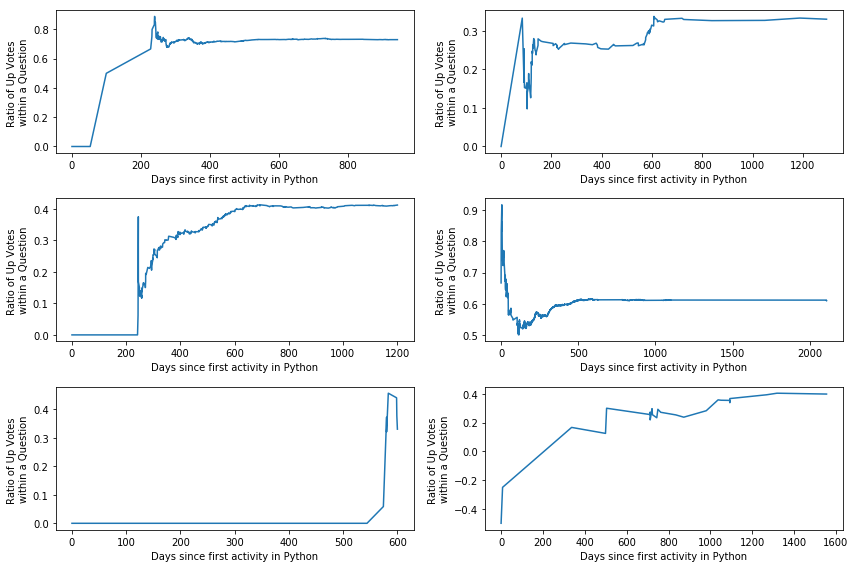

In [16]:
######## plots ###
plotEvolutionRandomUsers(rSummaryUpMetricAnswerFew,"R")
plotEvolutionRandomUsers(javaSummaryUpMetricAnswerFew,"JAVA")
plotEvolutionRandomUsers(pythonSummaryUpMetricAnswerFew,"Python")

In [17]:
def aggregateIndividualLearningCurves(summaryTableProbAccAnswer,thresExpertise,threshUsers):
    #possible timepoints from 0 to the maximum span.
    x_all = np.linspace(0, max(summaryTableProbAccAnswer["DifferenceDenominator"]),num=5000, endpoint=True)
    #variable initialization
    sumProbs = np.zeros(len(x_all))
    nrUsers = np.zeros(len(x_all))
    users = list(set(summaryTableProbAccAnswer[" OwnerUserId"].tolist()))
    #total = np.empty((len(x_all),len(users),))
    #total.fill(np.nan)
    consUsers=0 #considered users
    i=0
    #for each user:
    #linear interpolation - already checked that curve shape is similar to the ones obtained individually
    for user in users:
        xs_user=summaryTableProbAccAnswer["DifferenceNumerator"][summaryTableProbAccAnswer[" OwnerUserId"]==user].tolist()
        probs_user= summaryTableProbAccAnswer["UpMetric"][summaryTableProbAccAnswer[" OwnerUserId"]==user].tolist()
        
        #interpolation function for this user
        f1 = interp1d(xs_user,probs_user ,'linear')
        
        # only interpolated values are considered, meaning no extrapolated values
        subset_x_all=x_all[x_all<max(xs_user)]
        f1_int = f1(subset_x_all)
    
        
        # only users that are considered to achieve expertise will be taken into consideration for computing the learning curve
        if (min(probs_user[-5:])>thresExpertise):
            consUsers=consUsers+1
            #total[0:len(subset_x_all),i]=f1_int
            #update probability sums at each time point with the interpolated probabilities for this user
            sumProbs[0:len(subset_x_all)]=sumProbs[0:len(subset_x_all)]+f1_int
            #update nr users 
            nrUsers[0:len(subset_x_all)] = nrUsers[0:len(subset_x_all)]+1
            #i=i+1

    
    #Remove timepoints which have less than a threshold number of users
    noUsersPos = np.where(nrUsers>threshUsers)
    sumProbs=sumProbs[noUsersPos]
    nrUsers=nrUsers[noUsersPos]
    x_all=x_all[noUsersPos]
    #total = total[noUsersPos,:]
    probs=sumProbs/nrUsers
    
    print((len(users)-consUsers)/len(users), " were not considered")
    print (consUsers, " were considered in total")
    
    return([x_all,probs])



In [18]:
def plotAvgCurve(x_all,probs,language):    
    plt.figure()
    plt.xlabel("Days since first activity in " + language)
    plt.ylabel("Ratio of Up Votes \nwithin a Question")
    plt.plot(x_all, probs)
    plt.show()

In [19]:
aggregateIndividualLearningCurves(rSummaryUpMetricAnswerFew,-1.1,100)

0.0  were not considered
5063  were considered in total


[array([0.00000000e+00, 6.92543806e-01, 1.38508761e+00, ...,
        2.55548665e+03, 2.55617919e+03, 2.55687173e+03]),
 array([0.2178335 , 0.24069512, 0.24796639, ..., 0.45251844, 0.45248034,
        0.45252141])]

0.0  were not considered
5063  were considered in total


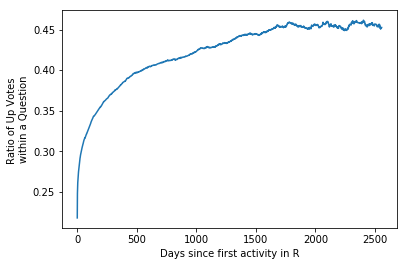

In [20]:
[Rx_all,Rprobs]=aggregateIndividualLearningCurves(rSummaryUpMetricAnswerFew,-1.1,100)
plotAvgCurve(Rx_all,Rprobs,"R")


0.0  were not considered
64556  were considered in total


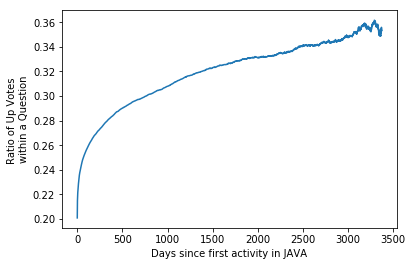

In [21]:
[Jx_all,Jprobs]=aggregateIndividualLearningCurves(javaSummaryUpMetricAnswerFew,-1.1,100)
plotAvgCurve(Jx_all,Jprobs,"JAVA")

0.01809904197972237  were not considered
35155  were considered in total


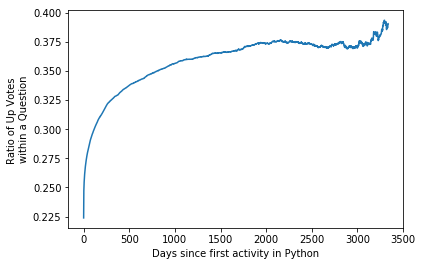

In [22]:
#Python
[Px_all,Pprobs]=aggregateIndividualLearningCurves(pythonSummaryUpMetricAnswerFew,-0.1,100)
plotAvgCurve(Px_all,Pprobs,"Python")

In [23]:
def aggregatePerWeek(summaryTable):
    summaryTable = summaryTable.sort_values(['OnlyDate'])
    uniqueTime = summaryTable['OnlyDate'].unique()

    uniqueTime = pd.DataFrame(uniqueTime)
    uniqueTime= uniqueTime.reset_index()
    uniqueTime= uniqueTime[1:]
    uniqueTime.columns= ['Index','OnlyDate']
    
    uniqueTime.insert(1, 'Day', range(0, 0 + len(uniqueTime)))

    uniqueTime['Week'] = np.where((uniqueTime['Day']%7)==0 , uniqueTime['Day']//7 ,uniqueTime['Day']//7)
    
#    print (uniqueTime)
    #summaryTable=summaryTable.sort_values(['OnlyDate',' OwnerUserId'])
    summaryTable= summaryTable.merge(uniqueTime, left_on='OnlyDate', right_on='OnlyDate', how='inner')

    #perWeekMetric= summaryTable.filter(items=['OnlyDate','Week', ' OwnerUserId','UpMetric'])

    
    return(summaryTable)

In [24]:
def filterUsers(perWeekTable):
    perWeekTable = perWeekTable.sort_values('OnlyDate').drop_duplicates(subset=['Week', ' OwnerUserId'], keep='last')
    return perWeekTable

In [25]:
rSummaryUpMetricAnswer['OnlyDate'] = pd.to_datetime(rSummaryUpMetricAnswer[' CreationDate'],errors="coerce")
rSummaryUpMetricAnswer['OnlyDate'] = rSummaryUpMetricAnswer['OnlyDate'].dt.date
rSummaryUpMetricAnswer= rSummaryUpMetricAnswer.sort_values(['OnlyDate'])
rPerWeekUpMetric = aggregatePerWeek(rSummaryUpMetricAnswer)
rPerWeekUpMetric = filterUsers(rPerWeekUpMetric)
rPerWeekUpMetric = rPerWeekUpMetric.sort_values(['Week',' OwnerUserId'])


In [26]:
rSummaryProbAccAnswer = rProbAcc
rSummaryProbAccAnswer['OnlyDate'] = pd.to_datetime(rProbAcc[' CreationDate'],errors="coerce")
rSummaryProbAccAnswer['OnlyDate'] = rSummaryProbAccAnswer['OnlyDate'].dt.date
rSummaryProbAccAnswer= rSummaryProbAccAnswer.sort_values(['OnlyDate'])
rPerWeekProbAcc = aggregatePerWeek(rProbAcc)
rPerWeekProbAcc = filterUsers(rPerWeekProbAcc)
rPerWeekProbAcc = rPerWeekProbAcc.sort_values(['Week',' OwnerUserId'])

In [27]:
rSummaryDegreeAnswer = rDegree
rSummaryDegreeAnswer['OnlyDate'] = pd.to_datetime(rDegree[' CreationDate'],errors="coerce")
rSummaryDegreeAnswer['OnlyDate'] = rSummaryDegreeAnswer['OnlyDate'].dt.date
rSummaryDegreeAnswer= rSummaryDegreeAnswer.sort_values(['OnlyDate'])
rPerWeekDegree = aggregatePerWeek(rDegree)
rPerWeekDegree = filterUsers(rPerWeekDegree)
rPerWeekDegree = rPerWeekDegree.sort_values(['Week',' OwnerUserId'])

In [28]:
upMetricVSprobAcc = pd.DataFrame()

rSummaryProbAccAnswer = rSummaryProbAccAnswer.sort_values([' CreationDate',' OwnerUserId'])
rSummaryUpMetricAnswer = rSummaryUpMetricAnswer.sort_values([' CreationDate',' OwnerUserId'])
rSummaryDegreeAnswer = rSummaryDegreeAnswer.sort_values([' CreationDate',' OwnerUserId'])

upMetricVSprobAcc['cumnetdeg'] = rSummaryDegreeAnswer['cumnetdeg']
upMetricVSprobAcc['ProbAcc'] = rSummaryProbAccAnswer['ProbAccAnswer']
upMetricVSprobAcc['UpMetric'] = rSummaryUpMetricAnswer['UpMetric']
rCorrProbDegree = upMetricVSprobAcc['ProbAcc'].corr(upMetricVSprobAcc['cumnetdeg'],method='spearman')
rCorrUpDegree = upMetricVSprobAcc['UpMetric'].corr(upMetricVSprobAcc['cumnetdeg'],method='spearman')
rCorrUpProb = upMetricVSprobAcc['ProbAcc'].corr(upMetricVSprobAcc['UpMetric'],method='spearman')
print('Correlation between UpMetric and ProbAcc')
print(rCorrUpProb)
print('Correlation between ProbAcc and Degree')
print(rCorrProbDegree)
print('Correlation between UpMetric and Degree')
print(rCorrUpDegree)


Correlation between UpMetric and ProbAcc
0.6586035483134429
Correlation between ProbAcc and Degree
0.0161781391132871
Correlation between UpMetric and Degree
0.01733532204124433


In [29]:
def getLastEigPerUser(table,usersTable):
   
    table = table.sort_values('CreationDate').drop_duplicates(subset=['UserId'], keep='last')
    usersTable = usersTable.sort_values('Id')
    table = table.sort_values('UserId')
    answersWithScore = table.merge(usersTable, left_on='UserId', right_on='Id', how='inner')
    table = answersWithScore.filter(items=['CreationDate', 'UserId','EigenCen','Reputation'])
    table = table.sort_values('UserId')
    return table

def getLastCloPerUser(table,usersTable):
 
    table = table.sort_values('CreationDate').drop_duplicates(subset=['UserId'], keep='last')
    usersTable = usersTable.sort_values('Id')
    table = table.sort_values('UserId')
    answersWithScore = table.merge(usersTable, left_on='UserId', right_on='Id', how='inner')
   # table = answersWithScore.filter(items=['CreationDate', 'UserId','Closenss','Reputation'])
    table= answersWithScore
   
    table = table.sort_values('UserId')
    
    return table

def getLastBetPerUser(table,usersTable):

    table = table.sort_values('CreationDate').drop_duplicates(subset=['UserId'], keep='last')
    usersTable = usersTable.sort_values('Id')
    table = table.sort_values('UserId')
    answersWithScore = table.merge(usersTable, left_on='UserId', right_on='Id', how='inner')
    table = answersWithScore.filter(items=['CreationDate', 'UserId','Betweenness','Reputation'])
    table = table.sort_values('UserId')
    return table

def getLastUpMetricPerUser(table,usersTable):
    table = table.sort_values('OnlyDate').drop_duplicates(subset=[' OwnerUserId'], keep='last')
    usersTable = usersTable.sort_values('Id')
    table = table.sort_values(' OwnerUserId')
    answersWithScore = table.merge(usersTable, left_on=' OwnerUserId', right_on='Id', how='inner')
    table = answersWithScore.filter(items=['OnlyDate','Week', ' OwnerUserId','UpMetric','Reputation'])
    table = table.sort_values(' OwnerUserId')
    return table

def getLastDegreePerUser(table,usersTable):
    table = table.sort_values('OnlyDate').drop_duplicates(subset=[' OwnerUserId'], keep='last')
    usersTable = usersTable.sort_values('Id')
    table = table.sort_values(' OwnerUserId')
    answersWithScore = table.merge(usersTable, left_on=' OwnerUserId', right_on='Id', how='inner')
    table = answersWithScore.filter(items=['OnlyDate','Week', ' OwnerUserId','cumnetdeg','Reputation'])
    table = table.sort_values(' OwnerUserId')
    return table

def getLastProbAccPerUser(table,usersTable):
    table = table.sort_values('OnlyDate').drop_duplicates(subset=[' OwnerUserId'], keep='last')
    usersTable = usersTable.sort_values('Id')
    table = table.sort_values(' OwnerUserId')
    answersWithScore = table.merge(usersTable, left_on=' OwnerUserId', right_on='Id', how='inner')
    table = answersWithScore.filter(items=['OnlyDate','Week', ' OwnerUserId','ProbAccAnswer','Reputation'])
    table = table.sort_values(' OwnerUserId')
    return table

In [30]:
# Compares UpMetric with Reputation Score
rUsers= rUsers.sort_values('Id')
lastUpMetricPerUserWithRep = getLastUpMetricPerUser(rSummaryUpMetricAnswer,rUsers)
lastUpMetricPerUserWithRep = lastUpMetricPerUserWithRep.sort_values(' OwnerUserId')

rCorrUpMetricRep = lastUpMetricPerUserWithRep['UpMetric'].corr(lastUpMetricPerUserWithRep['Reputation'],method='spearman')
print(rCorrUpMetricRep)


0.3855315150395398


In [31]:
# Compares Degree with Reputation Score
lastDegreePerUserWithRep = getLastDegreePerUser(rSummaryDegreeAnswer,rUsers)
lastDegreePerUserWithRep = lastDegreePerUserWithRep.sort_values(' OwnerUserId')
print('Correlation between Degree and Reputation')
rCorrDegreeRep = lastDegreePerUserWithRep['cumnetdeg'].corr(lastDegreePerUserWithRep['Reputation'],method='spearman')
print(rCorrDegreeRep)



Correlation between Degree and Reputation
0.18628872896906853


In [32]:
# Compares ProbAcc with Reputation Score
# get most recent Prob score per user and relates ProbAcc with Reputation
print('Correlation between ProbAcc and Reputation')
lastProbAccPerUserWithRep = getLastProbAccPerUser(rProbAcc,rUsers)
rCorrProbAccRep = lastProbAccPerUserWithRep['ProbAccAnswer'].corr(lastProbAccPerUserWithRep['Reputation'],method='spearman')
print(rCorrProbAccRep)

Correlation between ProbAcc and Reputation
0.3315679385561568


In [33]:
# corr between network features
print('Correlation between Betweenness and Eigen Centrality')
rCorrEigBet = rEig['EigenCen'].corr(rBetween['Betweenness'],method='spearman')
print(rCorrEigBet)
print('Correlation between Closeness and Eigen Centrality')
rCorrEigClo = rEig['EigenCen'].corr(rClose['Closness'],method='spearman')
print(rCorrEigClo)
print('Correlation between Betweenness and Closeness')
rCorrBetClo = rBetween['Betweenness'].corr(rClose['Closness'],method='spearman')
print(rCorrBetClo)

Correlation between Betweenness and Eigen Centrality
0.7089999067265067
Correlation between Closeness and Eigen Centrality
0.45664263931685395
Correlation between Betweenness and Closeness
0.12281515716175004


In [34]:
rBetween

,Unnamed: 0,Unnamed: 0.1,UserId,CreationDate,Betweenness,OnlyDate,Week
109622,109622,1968166,1968,2018-01-01,4.442539e+06,01-01-2018,450
109423,109423,7223,7223,2018-01-01,0.000000e+00,01-01-2018,450
109573,109573,143305429,143305,2018-01-01,5.199306e+07,01-01-2018,450
109475,109475,16192135,161921,2018-01-01,0.000000e+00,01-01-2018,450
109420,109420,16414817,164148,2018-01-01,5.477370e+05,01-01-2018,450
109507,109507,190277361,190277,2018-01-01,2.599473e+07,01-01-2018,450
109655,109655,229794117,229794,2018-01-01,2.984163e+06,01-01-2018,450
109562,109562,29569141,295691,2018-01-01,8.598740e+04,01-01-2018,450
109472,109472,322912323,322912,2018-01-01,1.314264e+07,01-01-2018,450
109509,109509,471093273,471093,2018-01-01,1.819206e+07,01-01-2018,450


In [35]:
# Compares Eigen Centrality with Reputation Score
print('Correlation between Eigen and Reputation')
lastEigPerUserWithRep = getLastEigPerUser(rEig,rUsers)
rCorrEigRep = lastEigPerUserWithRep['EigenCen'].corr(lastEigPerUserWithRep['Reputation'],method='spearman')
print(rCorrEigRep)

# Compares Betweenness with Reputation Score
print('Correlation between Betweeness and Reputation')
lastBetPerUserWithRep = getLastBetPerUser(rBetween,rUsers)
rCorrBetRep = lastBetPerUserWithRep['Betweenness'].corr(lastBetPerUserWithRep['Reputation'],method='spearman')
print(rCorrBetRep)

# Compares Closeness with Reputation Score
print('Correlation between Closeness and Reputation')
lastCloPerUserWithRep = getLastCloPerUser(rClose,rUsers)
rCorrCloRep = lastCloPerUserWithRep['Closness'].corr(lastCloPerUserWithRep['Reputation'],method='spearman')
print(rCorrCloRep)


Correlation between Eigen and Reputation
0.3619222753579946
Correlation between Betweeness and Reputation
0.26527105841507304
Correlation between Closeness and Reputation
0.28315684212084924


In [36]:
# Compares ProbAcc with Network features

rBetween = rBetween.sort_values(['Week','UserId'])
rClose = rClose.sort_values(['Week','UserId'])
rEig = rEig.sort_values(['Week','UserId'])
rBetProb = rBetween.merge(rPerWeekProbAcc, left_on=['UserId', 'Week'], right_on=[' OwnerUserId', 'Week'], suffixes= ('_n','_l'), how='inner')
rCloseProb= rClose.merge(rPerWeekProbAcc, left_on=['UserId', 'Week'], right_on=[' OwnerUserId', 'Week'], suffixes= ('_n','_l'),how='inner')
rEigProb= rEig.merge(rPerWeekProbAcc, left_on=['UserId', 'Week'], right_on=[' OwnerUserId', 'Week'], suffixes= ('_n','_l'),how='inner')

print('Correlation between ProbAcc and Betweenness')
rCorrProbBet = rBetProb['ProbAccAnswer'].corr(rBetProb['Betweenness'], method='spearman')
print(rCorrProbBet)

print('Correlation between ProbAcc and Closeness')
rCorrProbClo = rCloseProb['ProbAccAnswer'].corr(rCloseProb['Closness'], method='spearman')
print(rCorrProbClo)

print('Correlation between ProbAcc and Eigen')
rCorrProbEig = rEigProb['ProbAccAnswer'].corr(rEigProb['EigenCen'], method='spearman')
print(rCorrProbEig)



Correlation between ProbAcc and Betweenness
0.2473378028779954
Correlation between ProbAcc and Closeness
0.09888823521926829
Correlation between ProbAcc and Eigen
0.3336074991086927


In [37]:
# Compares UpMetric with Network features
rBetUp = rBetween.merge(rPerWeekUpMetric, left_on=['UserId', 'Week'], right_on=[' OwnerUserId', 'Week'], suffixes= ('_n','_l'), how='inner')
rCloseUp= rClose.merge(rPerWeekUpMetric, left_on=['UserId', 'Week'], right_on=[' OwnerUserId', 'Week'], suffixes= ('_n','_l'),how='inner')
rEigUp= rEig.merge(rPerWeekUpMetric, left_on=['UserId', 'Week'], right_on=[' OwnerUserId', 'Week'], suffixes= ('_n','_l'),how='inner')

print('Correlation between UpMetric and Betweenness')
rCorrUpBet = rBetUp['UpMetric'].corr(rBetUp['Betweenness'], method='spearman')
print(rCorrUpBet)

print('Correlation between UpMetric and Closeness')
rCorrUpClo = rCloseUp['UpMetric'].corr(rCloseUp['Closness'], method='spearman')
print(rCorrUpClo)

print('Correlation between UpMetric and Eigen')
rCorrUpEig = rEigUp['UpMetric'].corr(rEigUp['EigenCen'], method='spearman')
print(rCorrUpEig)

Correlation between UpMetric and Betweenness
0.23839279343817618
Correlation between UpMetric and Closeness
0.172652037882076
Correlation between UpMetric and Eigen
0.3057978064243643


In [38]:
# Compares Degree with Network features
rBetDegree = rBetween.merge(rPerWeekDegree, left_on=['UserId', 'Week'], right_on=[' OwnerUserId', 'Week'], suffixes= ('_n','_l'), how='inner')
rCloseDegree= rClose.merge(rPerWeekDegree, left_on=['UserId', 'Week'], right_on=[' OwnerUserId', 'Week'], suffixes= ('_n','_l'),how='inner')
rEigDegree= rEig.merge(rPerWeekDegree, left_on=['UserId', 'Week'], right_on=[' OwnerUserId', 'Week'], suffixes= ('_n','_l'),how='inner')

print('Correlation between Degree and Betweenness')
rCorrDegreeBet = rBetDegree['cumnetdeg'].corr(rBetDegree['Betweenness'], method='spearman')
print(rCorrDegreeBet)

print('Correlation between Degree and Closeness')
rCorrDegreeClo = rCloseDegree['cumnetdeg'].corr(rCloseDegree['Closness'], method='spearman')
print(rCorrDegreeClo)

print('Correlation between Degree and Eigen')
rCorrDegreeEig = rEigDegree['cumnetdeg'].corr(rEigDegree['EigenCen'], method='spearman')
print(rCorrDegreeEig)

Correlation between Degree and Betweenness
0.4564868405759946
Correlation between Degree and Closeness
0.22331366271972636
Correlation between Degree and Eigen
0.5490505602040131


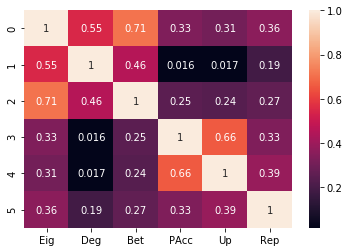

In [39]:
rCorrTable = pd.DataFrame()

#rCorrTable['row'] = ['Eig', 'Deg', 'Bet', 'PAcc','Up','Rep']
rCorrTable['Eig'] = [1,rCorrDegreeEig,rCorrEigBet,rCorrProbEig,rCorrUpEig,rCorrEigRep]
rCorrTable['Deg'] = [rCorrDegreeEig,1,rCorrDegreeBet,rCorrProbDegree,rCorrUpDegree,rCorrDegreeRep]
rCorrTable['Bet'] = [rCorrEigBet,rCorrDegreeBet,1,rCorrProbBet,rCorrUpBet,rCorrBetRep]
rCorrTable['PAcc']= [rCorrProbEig,rCorrProbDegree,rCorrProbBet,1,rCorrUpProb,rCorrProbAccRep]
rCorrTable['Up']  = [rCorrUpEig,rCorrUpDegree,rCorrUpBet,rCorrUpProb,1,rCorrUpMetricRep]
rCorrTable['Rep'] = [rCorrEigRep,rCorrDegreeRep,rCorrBetRep,rCorrProbAccRep,rCorrUpMetricRep,1]
#rCorrTable['Clo'] = [rCorrEigClo,1,rCorrBetClo,rCorrProbClo,rCorrUpClo,rCorrCloRep,rCorrDegreeClo]


#rCorrTable.set_index('row')

sns.heatmap(rCorrTable, annot=True)